##Course Assessment 4
The [dataset](https://www.consumerfinance.gov/data-research/) used in this project is published by CFPB which helps us to understand the problems in the financial marketplace. 
The dataset generally updated daily.
- The questions for descriptive analysis are listed in section **2.1 Data visualization**

- The machine learning model is for predicting the whether the company close the complaints with relief or not.

#### Initialization
- import libs
- initialize parameters

In [0]:
#import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import Window
from pyspark.sql import SQLContext
#from pyspark.sql.functions import col, udf
import pyspark.sql.functions as F
from pyspark.sql.functions import split, explode
#from pyspark.sql.functions import regexp_replace, trim, col, lower
from pyspark.sql.types import IntegerType
from pyspark.sql.types import StructType, StructField, DateType, IntegerType, StringType, DoubleType, TimestampType,ArrayType
from pyspark.ml.feature import Tokenizer, RegexTokenizer

NLP related installation and import

In [0]:
#word cloud
!pip install wordcloud
from wordcloud import WordCloud 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt

Collecting wordcloud
 Downloading wordcloud-1.8.1-cp38-cp38-manylinux1_x86_64.whl (371 kB)
▉ | 10 kB 7.5 MB/s eta 0:00:01 |█▊ | 20 kB 9.5 MB/s eta 0:00:01 |██▋ | 30 kB 7.5 MB/s eta 0:00:01 |███▌ | 40 kB 7.5 MB/s eta 0:00:01 |████▍ | 51 kB 7.3 MB/s eta 0:00:01 |█████▎ | 61 kB 6.8 MB/s eta 0:00:01 |██████▏ | 71 kB 7.4 MB/s eta 0:00:01 |███████ | 81 kB 7.7 MB/s eta 0:00:01 |████████ | 92 kB 7.9 MB/s eta 0:00:01 |████████▉ | 102 kB 8.1 MB/s eta 0:00:01 |█████████▊ | 112 kB 8.1 MB/s eta 0:00:01 |██████████▋ | 122 kB 8.1 MB/s eta 0:00:01 |███████████▌ | 133 kB 8.1 MB/s eta 0:00:01 |████████████▎ | 143 kB 8.1 MB/s eta 0:00:01 |█████████████▏ | 153 kB 8.1 MB/s eta 0:00:01 |██████████████ | 163 kB 8.1 MB/s eta 0:00:01 |███████████████ | 174 kB 8.1 MB/s eta 0:00:01 |███████████████▉ | 184 kB 8.1 MB/s eta 0:00:01 |████████████████▊ | 194 kB 8.1 MB/s eta 0:00:01 |█████████████████▋ | 204 kB 8.1 MB/s eta 0:00:01 |██████████████████▌ | 215 kB 8.1 MB/s eta 0:00:01 |███████████████████▍ | 225 kB 8.1 MB/s eta 0:00:01 |████████████████████▎ | 235 kB 8.1 MB/s eta 0:00:01 |█████████████████████▏ | 245 kB 8.1 MB/s eta 0:00:01 |██████████████████████ | 256 kB 8.1 MB/s eta 0:00:01 |███████████████████████ | 266 kB 8.1 MB/s eta 0:00:01 |███████████████████████▉ | 276 kB 8.1 MB/s eta 0:00:01 |████████████████████████▋ | 286 kB 8.1 MB/s eta 0:00:01 |█████████████████████████▌ | 296 kB 8.1 MB/s eta 0:00:01 |██████████████████████████▍ | 307 kB 8.1 MB/s eta 0:00:01 |███████████████████████████▎ | 317 kB 8.1 MB/s eta 0:00:01 |████████████████████████████▏ | 327 kB 8.1 MB/s eta 0:00:01 |█████████████████████████████ | 337 kB 8.1 MB/s eta 0:00:01 |██████████████████████████████ | 348 kB 8.1 MB/s eta 0:00:01 |██████████████████████████████▉ | 358 kB 8.1 MB/s eta 0:00:01 |███████████████████████████████▊| 368 kB 8.1 MB/s eta 0:00:01 |████████████████████████████████| 371 kB 8.1 MB/s 
Requirement already satisfied: numpy>=1.6.1 in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from wordcloud) (1.19.2)
Requirement already satisfied: matplotlib in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from wordcloud) (3.2.2)
Requirement already satisfied: pillow in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from wordcloud) (8.0.1)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from matplotlib->wordcloud) (1.3.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from matplotlib->wordcloud) (2.4.7)
Requirement already satisfied: cycler>=0.10 in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from matplotlib->wordcloud) (0.10.0)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from matplotlib->wordcloud) (2.8.1)
Requirement already satisfied: six in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from cycler>=0.10->matplotlib->wordcloud) (1.15.0)
Installing collected packages: wordcloud
Successfully installed wordcloud-1.8.1

In [0]:
#!/bin/bash
!pip install nltk
!pip install --upgrade pip
!nltk.downloader all

import nltk
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('ieer')
nltk.download('stopwords')
#stopwords = set(STOPWORDS) 
stopwords = nltk.corpus.stopwords.words('english')
english_words = set(nltk.corpus.words.words())
#########
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


Requirement already satisfied: nltk in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (3.5)
Requirement already satisfied: regex in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from nltk) (2020.10.15)
Requirement already satisfied: tqdm in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from nltk) (4.50.2)
Requirement already satisfied: joblib in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from nltk) (0.17.0)
Requirement already satisfied: click in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (from nltk) (7.1.2)
Requirement already satisfied: pip in /databricks/conda/envs/databricks-ml/lib/python3.8/site-packages (21.0.1)
/bin/bash: nltk.downloader: command not found
[nltk_data] Downloading package punkt to /home/root/nltk_data...
[nltk_data] Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data] /home/root/nltk_data...
[nltk_data] Package twitter_samples is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data] /home/root/nltk_data...
[nltk_data] Package averaged_perceptron_tagger is already up-to-
[nltk_data] date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data] /home/root/nltk_data...
[nltk_data] Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/root/nltk_data...
[nltk_data] Package words is already up-to-date!
[nltk_data] Downloading package ieer to /home/root/nltk_data...
[nltk_data] Package ieer is already up-to-date!
[nltk_data] Downloading package stopwords to /home/root/nltk_data...
[nltk_data] Package stopwords is already up-to-date!

In [0]:
#palette for seaborn
palette_colors = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878',
                    '#A040A0', '#F8D030','#E0C068','#EE99AC','#C03028', 
                    '#F85888', '#B8A038','#705898','#98D8D8','#7038F8']

#### 1.1 Data acquisition
- download [json format datasource](http://files.consumerfinance.gov/ccdb/complaints.json.zip) and unzip. Upload the unzipped json file to Databrick DBFS. The json file should be listed below.
  
- read json file

In [0]:
#dbfs:/FileStore/tables/complaints.json listed here
display(dbutils.fs.ls("dbfs:/FileStore/tables/"))

path,name,size
dbfs:/FileStore/tables/Matrices_for_ML_BB-1.ipynb,Matrices_for_ML_BB-1.ipynb,12948
dbfs:/FileStore/tables/Matrices_for_ML_BB.ipynb,Matrices_for_ML_BB.ipynb,12948
dbfs:/FileStore/tables/Unsupervised_Learning_PCA_BB.ipynb,Unsupervised_Learning_PCA_BB.ipynb,17665
dbfs:/FileStore/tables/complaints.csv,complaints.csv,1233411049
dbfs:/FileStore/tables/complaints.json,complaints.json,1942366519
dbfs:/FileStore/tables/exercise_pyspark_dataframe.ipynb,exercise_pyspark_dataframe.ipynb,30542
dbfs:/FileStore/tables/flight_model/,flight_model/,0
dbfs:/FileStore/tables/flight_weather.csv,flight_weather.csv,431664555


#####1.1.1 Pick up few rows for observation.
Here we can see the 4 types of data data fields:
- date columns (yyyy-mm-dd format)
- some categorical columns
- narrative column (sentences)
- location related columns (state, zipcode)

In [0]:
# have quick view of the content of this json file
dbutils.fs.head("dbfs:/FileStore/tables/complaints.json", 4096)  

[Truncated to first 4096 bytes]
Out[7]: '[\n{"date_received": "2019-09-24", "product": "Debt collection", "sub_product": "I do not know", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt is not yours", "complaint_what_happened": "transworld systems inc. \\nis trying to collect a debt that is not mine, not owed and is inaccurate.", "company_public_response": "", "company": "TRANSWORLD SYSTEMS INC", "state": "FL", "zip_code": "335XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-24", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3384392"},\n{"date_received": "2019-09-19", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Incorrect information on your report", "sub_issue": "Information belongs to someone else", "complaint_what_happened": "", "company_public_response": "Company has responded to the consumer and the CFPB and chooses not to provide a public response", "company": "Experian Information Solutions Inc.", "state": "PA", "zip_code": "15206", "tags": "", "consumer_consent_provided": "Consent not provided", "submitted_via": "Web", "date_sent_to_company": "2019-09-20", "company_response": "Closed with non-monetary relief", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3379500"},\n{"date_received": "2019-11-08", "product": "Debt collection", "sub_product": "I do not know", "issue": "Communication tactics", "sub_issue": "Frequent or repeated calls", "complaint_what_happened": "Over the past 2 weeks, I have been receiving excessive amounts of telephone calls from the company listed in this complaint. The calls occur between XXXX XXXX and XXXX XXXX to my cell and at my job. The company does not have the right to harass me at work and I want this to stop. It is extremely distracting to be told 5 times a day that I have a call from this collection agency while at work.", "company_public_response": "", "company": "Diversified Consultants, Inc.", "state": "NC", "zip_code": "275XX", "tags": "", "consumer_consent_provided": "Consent provided", "submitted_via": "Web", "date_sent_to_company": "2019-11-08", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "3433198"},\n{"date_received": "2021-01-28", "product": "Credit reporting, credit repair services, or other personal consumer reports", "sub_product": "Credit reporting", "issue": "Problem with a credit reporting company\'s investigation into an existing problem", "sub_issue": "Investigation took more than 30 days", "complaint_what_happened": "", "company_public_response": "", "company": "EQUIFAX, INC.", "state": "FL", "zip_code": "33432", "tags": "", "consumer_consent_provided": "", "submitted_via": "Web", "date_sent_to_company": "2021-01-28", "company_response": "Closed with explanation", "timely": "Yes", "consumer_disputed": "N/A", "complaint_id": "4102456"},\n{"date_received": "2019-09-15", "product": "Debt collection", "sub_product": "Other debt", "issue": "Attempts to collect debt not owed", "sub_issue": "Debt was result of identity theft", "complaint_what_happened": "Pioneer has committed several federal violations against me, a Private law abiding Federally Protected Consumer. Each violation is a statutory cost of {$1000.00} each, which does not include my personal cost and fees which shall be determined for taking time to address these issues. Violations committed against me include but not limited to : ( 1 ) Violated 15 USC 1692c ( a ) ; Communication without prior consent, expressed permission. ( 2 ) Violated 15 USC 1692d ; Harass and oppressive use of intercourse about an alleged debt. ( 3 ) Violated 15 USC 1692d ( l ) ; Attacking my reputation, accusing me of owing an alleged debt to you. ( 4 ) Violated 15 USC 1692e ( 9 ) ; Use/distribution of communication with auth

##### 1.1.2 Load data into dataframe

In [0]:
from pyspark.sql.types import DateType
#json format data file has been uploaded to this folder
file_name = '/FileStore/tables/complaints.json'
schema = """ `date_received`  DATE, 
`product`  STRING, 
`sub_product`  STRING, 
`issue`  STRING, 
`sub_issue`  STRING, 
`complaint_what_happened`  STRING, 
`company_public_response`  STRING, 
`company`  STRING, 
`state`  STRING, 
`zip_code`  STRING, 
`tags`  STRING, 
`consumer_consent_provided`  STRING, 
`submitted_via`  STRING, 
`date_sent_to_company`  DATE, 
`company_response`  STRING, 
`timely`  STRING, 
`consumer_disputed`  STRING, 
`complaint_id`  STRING""" 
#For a regular multi-line JSON file, set the multiLine option to true.
sdf = spark.read.option("multiline",True).\
  json("/FileStore/tables/complaints.json", schema=schema)

##### 1.1.3 Have a quick view with the first several rows to make sure data has been loaded smoothly

In [0]:
#take 5 rows and have a clearer view with pandas dataframe
pd.DataFrame(sdf.take(5), columns=sdf.columns).transpose()

Out[67]:

,0,1,2,3,4
date_received,2019-09-24,2019-09-19,2019-11-08,2021-01-28,2019-09-15
product,Debt collection,"Credit reporting, credit repair services, or o...",Debt collection,"Credit reporting, credit repair services, or o...",Debt collection
sub_product,I do not know,Credit reporting,I do not know,Credit reporting,Other debt
issue,Attempts to collect debt not owed,Incorrect information on your report,Communication tactics,Problem with a credit reporting company's inve...,Attempts to collect debt not owed
sub_issue,Debt is not yours,Information belongs to someone else,Frequent or repeated calls,Investigation took more than 30 days,Debt was result of identity theft
complaint_what_happened,transworld systems inc. \nis trying to collect...,,"Over the past 2 weeks, I have been receiving e...",,Pioneer has committed several federal violatio...
company_public_response,,Company has responded to the consumer and the ...,,,
company,TRANSWORLD SYSTEMS INC,Experian Information Solutions Inc.,"Diversified Consultants, Inc.","EQUIFAX, INC.",Pioneer Capital Solutions Inc
state,FL,PA,NC,FL,CA
zip_code,335XX,15206,275XX,33432,925XX


In [0]:
#total records and column counts
print(("Total", sdf.count()," records, ", len(sdf.columns), " columns"))
sdf.printSchema()

('Total', 1960448, ' records, ', 18, ' columns')
root
-- date_received: date (nullable = true)
-- product: string (nullable = true)
-- sub_product: string (nullable = true)
-- issue: string (nullable = true)
-- sub_issue: string (nullable = true)
-- complaint_what_happened: string (nullable = true)
-- company_public_response: string (nullable = true)
-- company: string (nullable = true)
-- state: string (nullable = true)
-- zip_code: string (nullable = true)
-- tags: string (nullable = true)
-- consumer_consent_provided: string (nullable = true)
-- submitted_via: string (nullable = true)
-- date_sent_to_company: date (nullable = true)
-- company_response: string (nullable = true)
-- timely: string (nullable = true)
-- consumer_disputed: string (nullable = true)
-- complaint_id: string (nullable = true)

#### 1.2 Data cleansing

##### 1.2.1 Filtering
- After checking date range of this dataset, we keep the sent date between 2012 and 2020 (full-year)

In [0]:
#data range
sdf.agg(F.max("date_sent_to_company"),F.min("date_sent_to_company"),F.max("date_received"),F.min("date_received")).show()

+-------------------------+-------------------------+------------------+------------------+
max(date_sent_to_company)|min(date_sent_to_company)|max(date_received)|min(date_received)|
+-------------------------+-------------------------+------------------+------------------+
 2021-02-06| 2011-12-01| 2021-02-06| 2011-12-01|
+-------------------------+-------------------------+------------------+------------------+

##### 1.2.2 Check null/emptyvalue
- replace empty **sub_issue** with issue value, replace empty **sub_product** with product value
- remove empty **states** and outliers name; remove empty rows from **consumer_consent_provided** column
- remove **zip_code**. Due to page limit, we don't focus on geographical analysis in this report. There're hundreds of thousand empty cells in this column, drop instead of fix it. 
- remove **complaint_id** which contributes nothing to analysis and prediction.
- remove **tags** for less reference value and most values of this column are empty.
- remove **company_public_response**

In [0]:
#check null value - no null values in this dataset
#display(sdf.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in sdf.columns]))
#check empty value count of every column
display(sdf.select([F.sum(F.when(F.col(c)=='', 1).otherwise(0)).alias(c) for c in sdf.columns]))

date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company_public_response,company,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_id
0,0,235165,0,598722,1295153,1138838,0,36146,188162,1709902,36163,0,0,2,0,0,0


In [0]:
#process
#remove rows with empty company_response
#remove outlier state
#remove identifier, zip_code
#replace empty sub_product with product value, so do the sub_issue
sdf_cleaned = sdf.filter(
        "date_received>'2011-12-31' and date_received<'2020-01-01' "+\
        "AND state !='' AND state!='UNITED STATES MINOR OUTLYING ISLANDS' " +\
        "AND company_response!='' AND consumer_consent_provided!=''" )\
        .drop("complaint_id","zip_code","company_public_response","tags") \
        .withColumn("sub_issue",F.when(sdf.sub_issue == '', F.col('issue')).otherwise(F.col('sub_issue'))) \
        .withColumn("sub_product",F.when(sdf.sub_product == '', F.col('product')).otherwise(F.col('sub_product')))

In [0]:
print(("Total", sdf_cleaned.count()," records, ", len(sdf_cleaned.columns), " columns"))

('Total', 1446484, ' records, ', 14, ' columns')

#### 1.2 Feature engineering

##### 1.2.1 New features
- Add the length of the complaint content as a new feature named **complaint_len** 
- Add **weekday_received** to show weekday number of the **date_received** column
- Merge **Credit card or prepaid card	** and **Credit card or prepaid card ** of the product column	to **Card** 
- Merge the product of **Credit reporting, credit repair services, or other personal consumer reports** and **Credit reporting**

In [0]:
from pyspark.sql import functions
from pyspark.sql.functions import date_format
# new date related features / merge product
sdf_cleaned = sdf_cleaned.withColumn("complaint_length", functions.length(F.col("complaint_what_happened"))).\
  withColumn("weekday_received", date_format(F.col("date_received"), "E")). \
  withColumn("year_received", F.year("date_received")). \
  withColumn("product", F.when(F.col('product').contains("Credit card"), "Card")\
             .when(F.col('product')=='Credit reporting, credit repair services, or other personal consumer reports', \
                   "Credit reporting").otherwise(F.col('product')))

##### 1.2.2 Company response
We choose **company response** as prediction goal because whether the company closed with relief or not is an interesting question, and it's meaningful business analysis. But the **company_response** consists several different unique values. Let's simplify the value to closed with relief or not.
clear the unclosed complaints.

In [0]:
#the distribution of company response
display(sdf_cleaned.groupBy("company_response").count())

company_response,count
Untimely response,6383
Closed with non-monetary relief,188847
Closed without relief,15964
In progress,2
Closed with monetary relief,80640
Closed with explanation,1132612
Closed,17424
Closed with relief,4612


In [0]:
#close with reliefe = 3 
mapping = {
        'Closed': '1',
        'Closed with explanation': '2',
        'Closed with monetary relief':'3',
        'Closed with non-monetary relief':'3',
        'Closed with relief':'3',
        'Closed without relief':'2'
    }
#replace string with code
sdf_cleaned = sdf_cleaned.replace(to_replace=mapping, subset=['company_response'])

Choose the product which exists the most relief to predict
Credit reporting

In [0]:
#make sure the category distributed evenly
display(sdf_cleaned.withColumn("relief",\
                       F.when(F.col("company_response")=='3',1).otherwise(0)).groupBy("product","relief").count())

product,relief,count
Credit reporting,1,105676
Debt collection,1,39500
Mortgage,1,25242
Payday loan,1,485
Card,1,47309
Virtual currency,0,17
Money transfers,1,860
Bank account or service,0,60218
Student loan,0,49507
"Payday loan, title loan, or personal loan",1,1142


In [0]:
#remove unclosed complaints, keep product=Credit reporting as machine learning dataset
sdf_ml = sdf_cleaned.\
  filter("company_response!='In progress' AND company_response!='Untimely response' " + \
        " AND product='Mortgage'")

#for visualization
sdf_data = sdf_cleaned

##### 1.2.2 One hot encoding
- After processing the null/empty values of each column in the previous steps, we transform these categorical values numeric by one hot encoding, so that the machine learning model can deal with it easily.

In [0]:
#check empty values
display(sdf_ml.select([F.sum(F.when(F.col(c)=='', 1).otherwise(0)).alias(c) for c in sdf_ml.columns]))

date_received,product,sub_product,issue,sub_issue,complaint_what_happened,company,state,consumer_consent_provided,submitted_via,date_sent_to_company,company_response,timely,consumer_disputed,complaint_length,weekday_received,year_received
0,0,0,0,0,226109,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

#categorical columns
cat_cols = [
#  'product',
  'sub_product',
#  'issue',
  'sub_issue',
#  'state',
#  'weekday_received',
#  'consumer_consent_provided',
  'submitted_via',
  'timely',
  'consumer_disputed'
#  'complaint_length'
]
# 'company_response',
stages = []
#string to number to vector
for col in cat_cols:
  stages.append(StringIndexer(inputCol=col, outputCol=col+'_index', handleInvalid='skip'))
  stages.append(OneHotEncoder(inputCols=[col+'_index'], outputCols=[col+'_vec'], dropLast=False))
#combine into one column:features
stages.append(VectorAssembler(inputCols=[c+'_vec' for c in cat_cols], outputCol='features'))
pipeline = Pipeline(stages=stages)
sdf_ml = pipeline.fit(sdf_ml).transform(sdf_ml)

In [0]:
#for machine learning
sdf_ml = sdf_ml.select('features','company_response')\
  .withColumn("label", F.col("company_response").cast("integer")).drop("company_response")
sdf_ml.printSchema()

root
-- features: vector (nullable = true)
-- label: integer (nullable = true)

In [0]:
#for visualization, save to table t_complaints
cols = [ 
  'company',
 'product',
 'sub_product',
 'issue',
 'sub_issue',
 'complaint_what_happened',
 'state',
 'consumer_consent_provided','date_received','weekday_received','year_received',
 'submitted_via',
 'date_sent_to_company',
 'company_response',
 'timely',
 'consumer_disputed']
#only keep columns for visualization
sdf_data = sdf_data.select(cols)
#save to table
sdf_data.createOrReplaceTempView('t_complaints')

#### 2.1 Data visualization

#####2.1.1 What are the most complained by multiple dimensions, have they changed over time. 
- by product by year
- by submitted channel by year

Define functions for process dataset and generating chart. The same function can be apply on the other categorical columns such as company, issue, and etc.
The logic of the function is group by specific dimension and year, count complaints and order descending, return the first N records.
With this function, we can see the top ranked complaints by specific dimension, and if the value of this dimension changed over years.

In [0]:
#we need to count group by year by each dimension, get the top rank items in each year, and visualize them with grouped chart. The below functions are for dealing with this issue. genChart
# for generating chart dataset
def genLinechart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.catplot(x="sent_year", y="count", data=df, aspect=3.0, kind='line',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))
#generate group bar chart
def genBarchart(name, group_field_name, top_n=4):
  df = getRankByYear(group_field_name)
  years = df["sent_year"].unique()
  #begin year
  year1 = years[0];
  #end year
  year2 = years[-1]
  with sns.axes_style('white'):
    #show complaints amount by group_field_name by year
    g = sns.catplot(x="sent_year", y="count", data=df, aspect=3.0, kind='bar',
                       palette=palette_colors,ci=None,hue=group_field_name, 
                       order=range(year1,year2),sharex=False,legend_out=False)
    g.set_ylabels('complaints amount')
    plt.legend(loc='best')
    #title - top n complaints by xxx begin_year - end_year
    g.fig.suptitle('top {} complaints by {} {} - {}'.format(top_n,name,year1,year2))

# group count and get top n of each group
def getRankByYear(field_name, top_n=4):
  #top n complaints amount by year by field_name
  df_topn = sqlContext.sql("SELECT year(date_received) as sent_year," + \
                  field_name +\
                  " ,count(1) AS count " +\
                  " FROM t_complaints " +\
                  " GROUP BY year(date_received)," + field_name)
  w = Window.partitionBy("sent_year").orderBy(F.col("count").desc())
  df_topn_pd = df_topn.select("*",F.row_number().over(w).alias('rank')).\
    filter(F.col('rank') <= top_n).orderBy(F.col("sent_year")).toPandas()
  return df_topn_pd

###### 2.1.1.1 Where did the complaints come from? Did that changed over time?

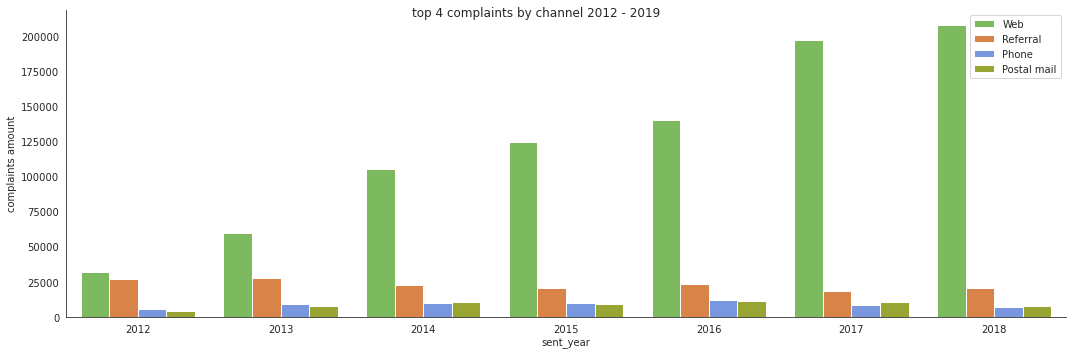

In [0]:
#group by channel by year to get the top 4 ranked complaints amount in each year
genBarchart("channel", "submitted_via")

###### 2.1.1.2 Which products get the most complaints? Have it changed over time? 
- Group count complaints by product by year

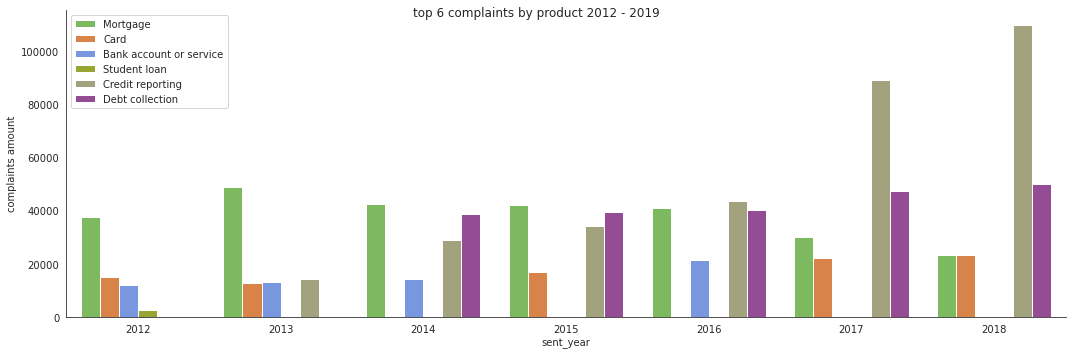

In [0]:
#show name and column name
genBarchart("product", "product",6)

Complaints amount distribution by company

Out[105]:

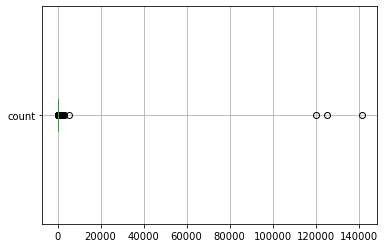

<matplotlib.axes._subplots.AxesSubplot at 0x7efe50986460>

In [0]:
df_company = sqlContext.sql("SELECT company,count(1) as count " + \
               "FROM t_complaints WHERE product = 'Credit reporting' " + 
               "GROUP BY company ").toPandas()
#df_company[['count']].hist(alpha=0.75,bins=35,figsize=(12,6))
#df_company.hist(bins=20,alpha = 0.5) 
#df_company.plot(kind = 'kde', secondary_y=True) 
#df_company.boxplot(column=['count'], rot=65, fontsize=12)
df_company.plot.box(vert=False, grid = True)


##### 2.1.2 complaints volumn by week by channel
This might be a guidance for the capacity allocation of the call center.

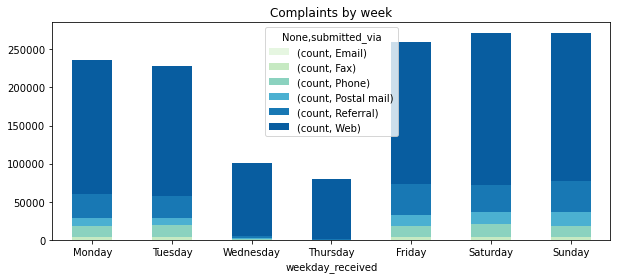

In [0]:
%matplotlib inline
from matplotlib.colors import ListedColormap
#count complaints group by day of week
df_chart = sdf_data.groupBy("weekday_received","submitted_via")\
  .agg({"submitted_via":"count"})\
  .withColumnRenamed("count(submitted_via)", "count").toPandas()

# show week labels

ax = df_chart.groupby(['weekday_received','submitted_via']).sum()\
  .unstack().plot(kind='bar',stacked=True,title='Complaints by week', \
                  colormap=ListedColormap(sns.color_palette("GnBu", 10)), rot=0, 
                  figsize=(10,4))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

##### 2.1.3 how the company respond
- How many companies have ever chosen monetary relief to their customers.
The company handle the complaint in different ways, one of the ways is close with monetary relief.
What's the proportation of this way in the financial companies? 
- Which kind of product inlvolved most in the companies closed by relief?

In [0]:
#which products have closed the complaints by monetay relief, the proportation of monetary relief in total complaints of the company
#almost 1/3 complaints of the prepaid card product has been closed by monetary relief
display(sqlContext.sql("SELECT product,sum(case when company_response='3' then 1 else 0 end) as count_monetary_close "+\
               ",count(1) as total FROM t_complaints group by product ")\
              .withColumn("rate", F.col("count_monetary_close")/F.col("total")*100))

product,count_monetary_close,total,rate
Debt collection,39500,272596,14.490308001584761
Virtual currency,0,17,0.0
Payday loan,485,5522,8.783049619703007
Money transfers,860,5155,16.682832201745878
"Money transfer, virtual currency, or money service",1814,12245,14.81420988158432
Checking or savings account,13621,52152,26.117886178861788
Mortgage,25242,288002,8.764522468593968
Card,47309,150303,31.47575231365974
Prepaid card,1655,3776,43.829449152542374
Credit reporting,105676,458921,23.02705694444142


##### 2.1.4 What the consumers's voice about specific product (NLP)
By taking some sampling data, we have seen what the data looks like.
- **complaint_what_happened** is the description of what that consumer complained. By exacting the most frequently words from the description, can we find more detail clues than the issue, sub_issue, product and sub_product. 
 - Clearing text from punctuation (regexp_replace)
 - Tokenization (Tokenizer)
 - Delete stop words (StopWordsRemover)
 - Stematization (SnowballStemmer)
 - Filtering short words

In [0]:
from nltk.tokenize import sent_tokenize, word_tokenize

vstopwords = np.append(stopwords,["x","xx","xxx","xxxx","xxxxx","xxxxxxxx","xx/xx/xxxx","word","count"])
#extract content from specific field of the dataframe, and return 
def parseContent(df_story, field_name):
  #lower 
  df_story_clean = df_story.select("year_received",field_name, (F.lower(F.regexp_replace(field_name, 
                                                                         "[^a-zA-Z\\s]", "")).alias('out1')))
  #split story into words
  tokenizer = Tokenizer(inputCol="out1", outputCol="out2")
  #private infor has been replaced with x before the dataset published, such as date, name...
  #remove stop words
  stopWordsRemover = StopWordsRemover(inputCol='out2', outputCol='out3' ,stopWords=stopwords)
  #stem
  stemmer = SnowballStemmer('english')

  udf_stem = udf(lambda words: [stemmer.stem(word) for word in words if len(word)>3 and word in english_words ], ArrayType(StringType()))
  
  #pipeline
  pipeline = Pipeline(stages=[tokenizer, stopWordsRemover])
  return pipeline.fit(df_story_clean).transform(df_story_clean) \
      .select("year_received",field_name,"out3") \
      .drop("out1","out2") \
      .withColumn("words", udf_stem(F.col("out3"))).drop('out3')

In [0]:
#show words cloud
def show_words_cloud(sdf,title):
  df = sdf.select(explode("words").alias('word')).\
  groupby('word').count().sort(F.desc("count")).toPandas()  
  
  wc = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(df.to_string()) 
  
  # plot the WordCloud image                        
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wc) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.title(title)
  plt.show() 

What happened with the **Prepaid card**

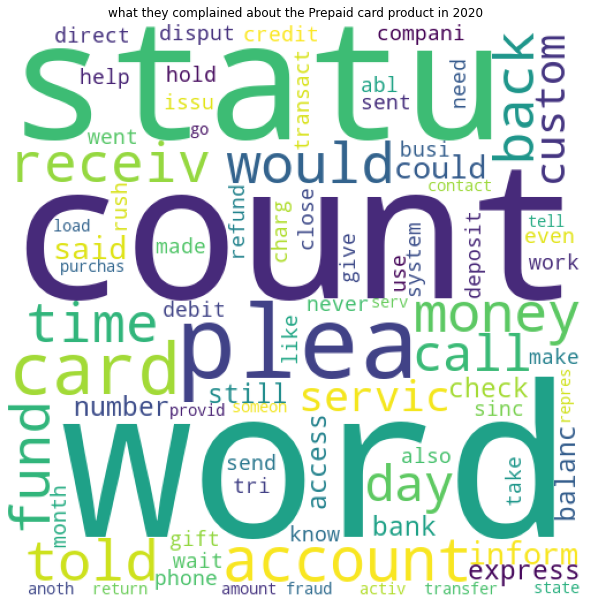

In [0]:
# sub_product is 'Credit reporting' since 2017
# as the words cloud resource
sdf_content = sqlContext.sql("SELECT year_received,complaint_what_happened " + \
          " FROM t_complaints WHERE " +\
          " product = 'Prepaid card' " +\
          " AND complaint_what_happened!='' ")
#parse the text of this dataset
df_words = parseContent(sdf_content,"complaint_what_happened")
#show words lcoud
show_words_cloud(df_words,"what they complained about the Prepaid card product in 2020")

#### 3.1 Machine learning

##### 3.1.1 Training and testing set

In [0]:
#split into 0.8 for training, 0.2 for testing
train_sdf, test_sdf = sdf_ml.randomSplit([0.8, 0.2], seed=2021)

##### 3.1.2 Decision tree
- training & testing
- evaluation
- hyperparameter tunning

In [0]:
dt_model = DecisionTreeClassifier(labelCol="label",
                            featuresCol="features").fit(train_sdf)
predictions1 = dt_model.transform(test_sdf)

In [0]:
#evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('DecisionTreeClassifier Accuracy:', evaluator.evaluate(predictions1,{evaluator.metricName:'accuracy'}))
print('DecisionTreeClassifier F1-Score:', evaluator.evaluate(predictions1,{evaluator.metricName:'f1'}))
print('DecisionTreeClassifier Recall:', evaluator.evaluate(predictions1,{evaluator.metricName:'weightedRecall'}))

DecisionTreeClassifier Accuracy: 0.8921445732790139
DecisionTreeClassifier F1-Score: 0.8412908303850077
DecisionTreeClassifier Recall: 0.8921445732790139

##### 3.1.2 Random forest

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf_model = RandomForestClassifier(labelCol='label', 
                            featuresCol='features',
                            maxDepth=5).fit(train_sdf)
predictions2 = rf_model.transform(test_sdf)

In [0]:
#evaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('RandomForestClassifier Accuracy:', evaluator.evaluate(predictions2,{evaluator.metricName:'accuracy'}))
print('RandomForestClassifier F1-Score:', evaluator.evaluate(predictions2,{evaluator.metricName:'f1'}))
print('RandomForestClassifier Recall:', evaluator.evaluate(predictions2,{evaluator.metricName:'weightedRecall'}))

DecisionTreeClassifier Accuracy: 0.8921445732790139
DecisionTreeClassifier F1-Score: 0.8412908303850077
DecisionTreeClassifier Recall: 0.8921445732790139

##### 3.1.4 Hyperparameter tuning
Finding the best parameter for the model.

In [0]:
# Create an initial RandomForest model.
rf_model2 = RandomForestClassifier(labelCol="label", featuresCol="features").fit(train_sdf)
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 5])
             .addGrid(rf.maxBins, [10])
             .addGrid(rf.numTrees, [5])
             .build())

# Create 5-fold CrossValidator
rfcv = CrossValidator(estimator = rf_model2,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

# Use test set here so we can measure the accuracy of our model on new data
predictions3 = rf_model2.transform(test_sdf)

In [0]:
print('RandomForestClassifier Accuracy:', evaluator.evaluate(predictions3,{evaluator.metricName:'accuracy'}))
print('RandomForestClassifier F1-Score:', evaluator.evaluate(predictions3,{evaluator.metricName:'f1'}))
print('RandomForestClassifier Recall:', evaluator.evaluate(predictions3,{evaluator.metricName:'weightedRecall'}))

RandomForestClassifier Accuracy: 0.8921445732790139
RandomForestClassifier F1-Score: 0.8412908303850077
RandomForestClassifier Recall: 0.8921445732790139